# Vizualisation of the track degradation in curves of Malmbanan

## Reading input data

We start by reading data from all the bandelar 111, 113, 116-119 with filenames in the form of RPM Rälslitage i kurva_111.csv. We then combine them into one dataframe.

In [55]:
import pandas as pd
import glob

# Step 1: Define the file path and pattern
file_pattern = "RPM Rälslitage i kurva_*.csv"

# Step 2: Read all files matching the pattern
file_list = glob.glob(file_pattern)

# Step 3: Create a dictionary to store DataFrames
dataframes = {}

for file in file_list:
    try:
        # Extract a unique key for each DataFrame (e.g., from the filename)
        key = file.split("_")[-1].replace(".csv", "")  # Extract part of the filename for identification
        # Read the CSV file into a DataFrame with ; as the delimiter
        df = pd.read_csv(file, delimiter=';', encoding='ISO-8859-1')  # Adjust encoding if needed
        # Store the DataFrame in the dictionary
        dataframes[key] = df
        print(f"Successfully loaded {file} into DataFrame with key '{key}'")
    except Exception as e:
        print(f"Error reading {file}: {e}")

Successfully loaded RPM Rälslitage i kurva_111.csv into DataFrame with key '111'
Successfully loaded RPM Rälslitage i kurva_113.csv into DataFrame with key '113'
Successfully loaded RPM Rälslitage i kurva_116.csv into DataFrame with key '116'
Successfully loaded RPM Rälslitage i kurva_117.csv into DataFrame with key '117'
Successfully loaded RPM Rälslitage i kurva_118.csv into DataFrame with key '118'
Successfully loaded RPM Rälslitage i kurva_119.csv into DataFrame with key '119'


In [56]:
# Combine all DataFrames in the dictionary into a single DataFrame
try:
    combined_dataframe = pd.concat(dataframes.values(), ignore_index=True)
    print("Successfully combined all DataFrames into one.")
except Exception as e:
    print(f"Error combining DataFrames: {e}")

Successfully combined all DataFrames into one.


## Cleaning and preprocessing

We need to process some columns to get correct format of info.

In [57]:
import re

# Correct formatting of 'Medel Spårvidd Cirkulärkurva' to numeric
combined_dataframe['Medel Spårvidd Cirkulärkurva'] = combined_dataframe['Medel Spårvidd Cirkulärkurva'].str.replace(',', '.').astype(float)

combined_dataframe['Startläge'] = combined_dataframe['Startläge'].str.replace(',', '.')
combined_dataframe['Slutläge'] = combined_dataframe['Slutläge'].str.replace(',', '.')

# 1. Extract Length from Startläge and Slutläge
def extract_position(value):
    """Extract numeric value from Startläge/Slutläge."""
    position = re.search(r'(\d+)(\s*\+\s*)(\d+)', value)
    if position:
        return int(position.group(1))*1000 + int(position.group(3))  # Convert to meters
    return None


combined_dataframe['Start_m'] = combined_dataframe['Startläge'].apply(extract_position)
combined_dataframe['End_m'] = combined_dataframe['Slutläge'].apply(extract_position)
combined_dataframe['length'] = abs(combined_dataframe['End_m'] - combined_dataframe['Start_m'])  # Calculate length

# Drop intermediate columns if not needed
combined_dataframe.drop(['Start_m', 'End_m'], axis=1, inplace=True)

# 2. Extract Date of Measurement from Mätning Spårvidd
def extract_measurement_date(value):
    """Extract date and time from Mätning Spårvidd."""
    match = re.search(r'SPL_(\d{6})(\d{4})', value)
    if match:
        date = match.group(1)  # e.g., 150727
        time = match.group(2)  # e.g., 0844
        formatted_date = f"20{date[:2]}-{date[2:4]}-{date[4:]} {time[:2]}:{time[2:]}"
        return formatted_date
    return None

def extract_measurement_date_H(value):
    """Extract date and time from Mätning, e.g., from RPM_1608100911A_111_E_1417_874 extract 2016-08-10 09:11."""
    match = re.search(r'RPM_(\d{6})(\d{4})', value)
    if match:
        date = match.group(1)  # e.g., 160810
        time = match.group(2)  # e.g., 0911
        formatted_date_time = f"20{date[:2]}-{date[2:4]}-{date[4:]} {time[:2]}:{time[2:]}"  # Format as YYYY-MM-DD HH:MM
        return formatted_date_time
    return None



# Apply the function only when the value is not NaN
combined_dataframe['Measurement Date'] = combined_dataframe['Mätning Spårvidd'].apply(
    lambda x: extract_measurement_date(x) if pd.notna(x) else pd.NaT
)

# Step 1: Convert `Radie` to a numeric column and create `Radie_Abs_Value`
combined_dataframe['Radie'] = pd.to_numeric(combined_dataframe['Radie'], errors='coerce')  # Convert to numeric, set invalid parsing to NaN

combined_dataframe['Radie_Abs_Value'] = combined_dataframe['Radie'].abs()  # Create absolute value column


### Important for H-damage plotting
combined_dataframe['Medel H Cirkulärkurva'] = combined_dataframe['Medel H Cirkulärkurva'].str.replace(',', '.')

# Apply the function only when the value is not NaN
combined_dataframe['Measurement Date H'] = combined_dataframe['Mätning'].apply(
    lambda x: extract_measurement_date_H(x) if pd.notna(x) else pd.NaT
)

In [58]:
# Remove duplicates based on 'Bandel', 'Startläge', 'Slutläge'
df_unique = combined_dataframe.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

print(len(df_unique))

# Now group by unique combinations and sum the 'length'
length_sum = df_unique.groupby(['Bandel', 'Startläge', 'Slutläge'])['length'].sum()

# Optionally, check the result
print(sum(length_sum))

1713
500110


## Plotting gauge widening

Some additional cleaning of the dataframe; First, Radie should be a number, also create a column with Radie_Abs_Value (in absolute value). Then, we remove rows where Medel Spårvidd Cirkulärkurva is less than 5, then the rows with negative values should be set to zero. Also keep only the main track.

In [59]:
# Assuming `combined_dataframe` is the DataFrame
df = combined_dataframe.copy()

# remove all rows with missing gauge widening measurement, i.e. rows where 'Mätning Spårvidd' is missing
df = df[df['Mätning Spårvidd'].notna()]

# Step 2: Filter out rows where `Medel Spårvidd Cirkulärkurva` is less than 5
df = df[df['Medel Spårvidd Cirkulärkurva'] >= 5]

# Step 3: Set negative values in `Medel Spårvidd Cirkulärkurva` to zero
df['Medel Spårvidd Cirkulärkurva'] = df['Medel Spårvidd Cirkulärkurva'].apply(lambda x: max(x, 0))

# Also keep only the main track.
df = df[df['Spårnamn'] == 'E']

In [60]:
# Remove duplicates based on 'Bandel', 'Startläge', 'Slutläge'
df_unique = df.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

print(len(df_unique))

# Now group by unique combinations and sum the 'length'
length_sum = df_unique.groupby(['Bandel', 'Startläge', 'Slutläge'])['length'].sum()

# Optionally, check the result
print(sum(length_sum))

1052
390287


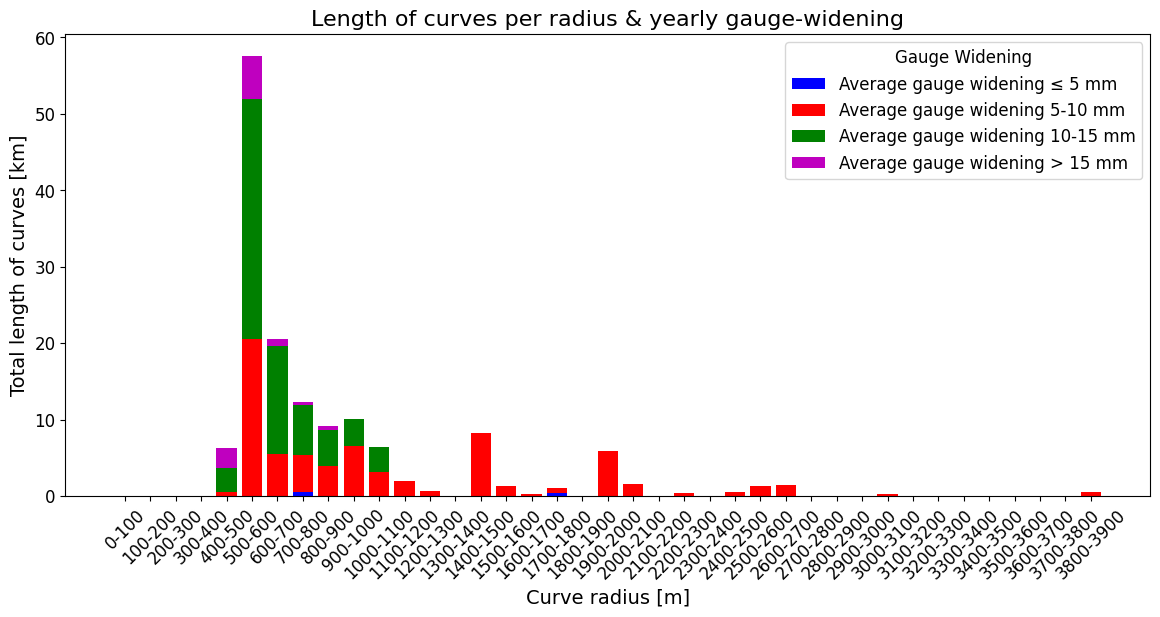

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Aggregate data by unique curves
df_agg = df.groupby(['Bandel', 'Startläge', 'Slutläge']).agg({
    'Radie_Abs_Value': 'first',  # Retain the first (unique for each curve)
    'length': 'first',  # Take the first length value (avoiding duplicates)
    'Medel Spårvidd Cirkulärkurva': 'mean'  # Average gauge widening for multiple observations
}).reset_index()

# Step 2: Convert length to kilometers
df_agg['length'] = df_agg['length'] / 1000  # Convert meters to kilometers

# Step 3: Define categories for `Radie` (Curve radius) with 100m increments
bins = np.arange(0, 4000, 100)  # Radius bins from 0 to 4000 in steps of 100
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(len(bins) - 1)]  # Create interval labels
df_agg['Radie Category'] = pd.cut(df_agg['Radie_Abs_Value'], bins=bins, labels=labels, right=False)

# Step 4: Define gauge widening categories based on `Medel Spårvidd Cirkulärkurva`
df_agg['Gauge Widening Category'] = pd.cut(
    df_agg['Medel Spårvidd Cirkulärkurva'],
    bins=[-np.inf, 5, 10, 15, np.inf],
    labels=['≤ 5 mm', '5-10 mm', '10-15 mm', '> 15 mm']
)

# Step 5: Group aggregated data by `Radie Category` and `Gauge Widening Category`, summing unique lengths
grouped = df_agg.groupby(['Radie Category', 'Gauge Widening Category'], observed=False)['length'].sum().unstack(fill_value=0)

# Step 6: Prepare data for plotting
R_cat = np.arange(len(grouped.index))  # One bar per Radie Category
width = 0.8  # Bar width

# Convert the grouped DataFrame into a NumPy array for stacking
stack_data = grouped.values

# Step 7: Plot the stacked bar chart
plt.figure(figsize=(14, 6))
ax = plt.axes()

# Stacked bar plot
bottoms = np.zeros(len(R_cat))  # Initialize the bottom positions for stacking
categories = grouped.columns  # Gauge widening categories

# Colors for each category
colors = ['b', 'r', 'g', 'm']

for i, category in enumerate(categories):
    ax.bar(
        R_cat,
        stack_data[:, i],
        width=width,
        bottom=bottoms,
        color=colors[i],
        label=f'Average gauge widening {category}'
    )
    bottoms += stack_data[:, i]  # Update bottom for the next stack

# Step 8: Customize plot
plt.xticks(R_cat, grouped.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Total length of curves [km]', fontsize=14)  # Updated label to km
plt.xlabel('Curve radius [m]', fontsize=14)
plt.legend(fontsize=12, title='Gauge Widening', title_fontsize=12)
plt.title('Length of curves per radius & yearly gauge-widening', fontsize=16)

# Optional: Save the figure
# plt.savefig('stacked_curve_length_plot.svg', bbox_inches='tight')

# Show the plot
plt.show()


### Plotting H-damage

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming `combined_dataframe` is the DataFrame
df = combined_dataframe.copy()

# Assuming `df` is your DataFrame and 'Measurement Date' is in datetime format
df['Measurement Date H'] = pd.to_datetime(df['Measurement Date H'], errors='coerce')

# Convert 'Medel H Cirkulärkurva' to float (handle any invalid entries)
df['Medel H Cirkulärkurva'] = pd.to_numeric(df['Medel H Cirkulärkurva'], errors='coerce')

# Step 1: Sort the DataFrame by curve identifiers and measurement date
df.sort_values(by=['Bandel', 'Startläge', 'Slutläge', 'Measurement Date H'], inplace=True)

# Step 2: Calculate the annual H-damage rate
df['H Change'] = df.groupby(['Bandel', 'Startläge', 'Slutläge'])['Medel H Cirkulärkurva'].diff()
df['Time Diff'] = df.groupby(['Bandel', 'Startläge', 'Slutläge'])['Measurement Date H'].diff().dt.days / 365.0


# Avoid division by zero or NaN issues
df = df[df['Time Diff'].notna() & (df['Time Diff'] != 0)]
df['H Change Rate'] = df['H Change'] / df['Time Diff']

# Also keep only the main track.
df = df[df['Spårnamn'] == 'E']

In [63]:
# Remove duplicates based on 'Bandel', 'Startläge', 'Slutläge'
df_unique = df.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

print(len(df_unique))

# Now group by unique combinations and sum the 'length'
length_sum = df_unique.groupby(['Bandel', 'Startläge', 'Slutläge'])['length'].sum()

# Optionally, check the result
print(sum(length_sum))

1012
354980


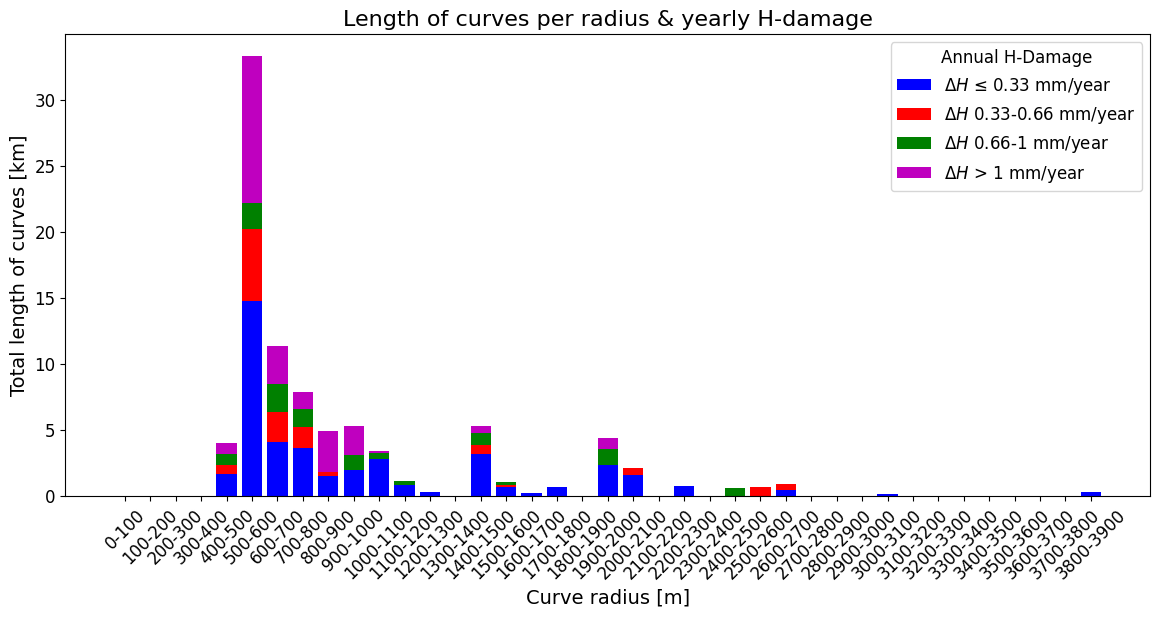

In [64]:
# Step 3: Aggregate by unique curves to get the average H-damage rate
df_agg = df.groupby(['Bandel', 'Startläge', 'Slutläge']).agg({
    'Radie_Abs_Value': 'first',  # Retain the first radius (unique for each curve)
    'length': 'first',  # Retain the first length (unique for each curve)
    'H Change Rate': 'mean'  # Average H-damage rate (mm/year)
}).reset_index()

# Step 4: Convert length to kilometers
df_agg['length'] = df_agg['length'] / 1000  # Convert meters to kilometers

# Step 5: Define categories for `Radie` (Curve radius) with 100m increments
bins = np.arange(0, 4000, 100)  # Radius bins from 0 to 4000 in steps of 100
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(len(bins) - 1)]  # Interval labels
df_agg['Radie Category'] = pd.cut(df_agg['Radie_Abs_Value'], bins=bins, labels=labels, right=False)

# Step 6: Define H-damage rate categories (mm/year) with updated bins
df_agg['H-Damage Category'] = pd.cut(
    df_agg['H Change Rate'],
    bins=[-np.inf, 0.33, 0.66, 1, np.inf],
    labels=['≤ 0.33 mm/year', '0.33-0.66 mm/year', '0.66-1 mm/year', '> 1 mm/year']
)

# Step 7: Group aggregated data by `Radie Category` and `H-Damage Category`, summing unique lengths
grouped = df_agg.groupby(['Radie Category', 'H-Damage Category'], observed=False)['length'].sum().unstack(fill_value=0)

# Step 8: Prepare data for plotting
R_cat = np.arange(len(grouped.index))  # One bar per Radie Category
width = 0.8  # Bar width

# Convert the grouped DataFrame into a NumPy array for stacking
stack_data = grouped.values

# Step 9: Plot the stacked bar chart
plt.figure(figsize=(14, 6))
ax = plt.axes()

# Stacked bar plot
bottoms = np.zeros(len(R_cat))  # Initialize the bottom positions for stacking
categories = grouped.columns  # H-damage categories

# Colors for each category
colors = ['b', 'r', 'g', 'm']

for i, category in enumerate(categories):
    ax.bar(
        R_cat,
        stack_data[:, i],
        width=width,
        bottom=bottoms,
        color=colors[i],
        label=f'$\Delta H$ {category}'
    )
    bottoms += stack_data[:, i]  # Update bottom for the next stack

# Step 10: Customize plot
plt.xticks(R_cat, grouped.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Total length of curves [km]', fontsize=14)
plt.xlabel('Curve radius [m]', fontsize=14)
plt.legend(fontsize=12, title='Annual H-Damage', title_fontsize=12)
plt.title('Length of curves per radius & yearly H-damage', fontsize=16)

# Optional: Save the figure
# plt.savefig('stacked_H_damage_plot.svg', bbox_inches='tight')

# Show the plot
plt.show()